There are SIRs and co. for this. I will test it with physics informed model. Some

$S(t)= -S(t)\alpha I(t) + \beta D(t) + \gamma A(t) + \delta R(t)$


1. $S(t)$: Susceptible
2. $I(t)$: Infectious
3. $D(t)$: Diagnosed
4. $H(t)$: Healing
5. $A(t)$: Ailing
6. $E(t)$: Extinct
7. $T(t)$: Threatened
8. $R(t)$: Recognized

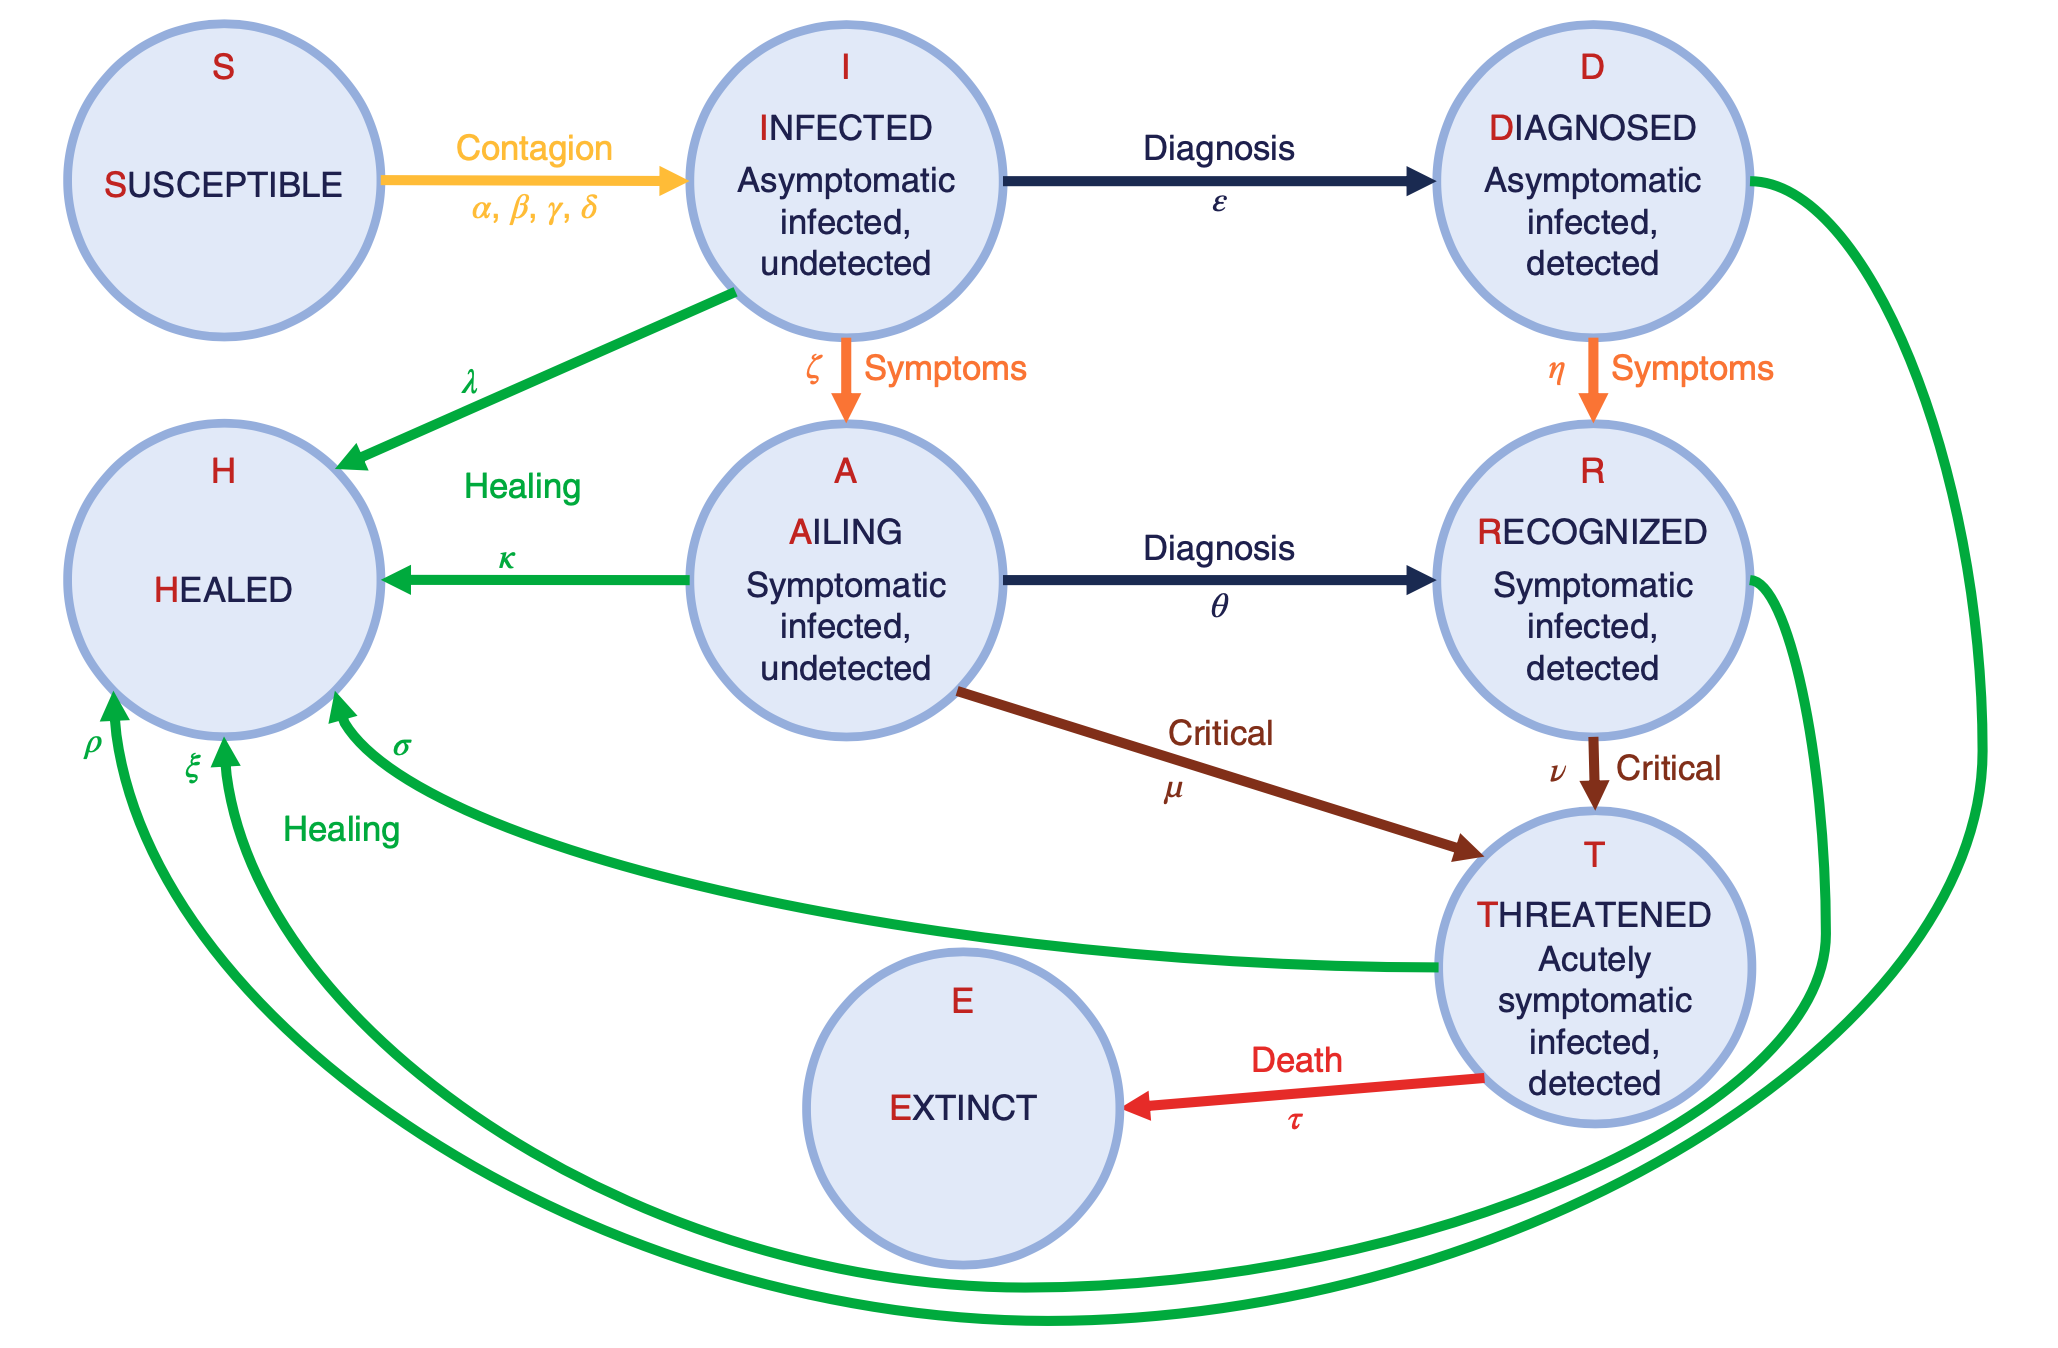

To estimate:

$\alpha, \beta\, \gamma, \delta$


----
SUEIR
Unobserved:
- Susceptible: Potentially have diesase
- Exposed: Incubation period,  during which individuals who have been exposed to the virus may not be as contagious as the infectious individuals. **NOTE**: Not in the SIDARTHA model because there is infected individuals can transmit the virus at an early, preclinical stage of the disease
(https://doi.org/10.1093/ https://doi.org/10.1016/s0140-6736(20)30528-6 https://doi.org/10.1056/nejmc2001468
https://doi.org/10.15585/mmwr.mm6913e1)
- Unreport recovered

Observed:
- Infected
- Recover
- Death

----
SIDARTHA
Unobeserved: 
- Susceptible
Observed: 
- Infected, Healing, Extinct

Exposed (E) models the incubation period, Infected (I) denotes the infectious who currently have the disease, and Re- moved/Recovered (R)

Covid 19 control theory

## Set up

- Recovery data, and hence, active data to be discountinued after 4th August 2021. (https://github.com/CSSEGISandData/COVID-19/issues/4465)
- We will only use data before that date, to get the most data to feed to the model
- The first cases of Covid in Canada, according to the data, are on 28 Jan 2020

In [1]:
from datetime import datetime
from pathlib import Path
from matplotlib import pyplot as plt

import tikzplotlib

In [2]:
def filename_to_datetime(filename):
    return datetime.strptime(Path(filename).stem, '%m-%d-%Y')

In [3]:
def last_update_todatetime(df, column='Last_Update'):
    try:
        return pd.to_datetime(df[column], format="%Y-%m-%d %H:%M:%S")
    except ValueError:
        try:
            return pd.to_datetime(df[column], format="%m/%d/%Y %H:%M")
        except ValueError:
            try:
                return pd.to_datetime(df[column], format="%Y-%m-%dT%H:%M:%S")     
            except ValueError:
                return pd.to_datetime(df[column], format="%m/%d/%y %H:%M")

In [4]:
import os
import pandas as pd
from pathlib import PosixPath

direc = os.path.join("COVID-19-master", "csse_covid_19_data", "csse_covid_19_daily_reports") # Directory that contains daily report csv files.
list_csv = sorted(list(PosixPath(direc).glob('*.csv')), key=filename_to_datetime)
canada = []
for file in list_csv:
    if filename_to_datetime(file) <= datetime(month=8, day=4, year=2021) and \
       filename_to_datetime(file) >= datetime(month=1, day=28, year=2020) :
        sample = pd.read_csv(file)
        if "Country/Region" in sample.columns:
            sample = sample.rename({"Country/Region": "Country_Region", "Province/State": "Province_State", "Last Update": "Last_Update"}, axis=1)
        sample = sample[sample["Country_Region"] == "Canada"]
        total_sample = sample[["Confirmed", "Recovered", "Deaths"]].sum()
        for non_state in ['Diamond Princess', 'Grand Princess', 'Repatriated Travellers']:
            if non_state in sample.index:
                sample = sample.drop(non_state)
        sample = sample.fillna(0)
        total_sample['Last_Update'] = last_update_todatetime(sample, 'Last_Update').max()
        canada.append(total_sample)
        
canada=pd.DataFrame(canada)

In [5]:
canada

,Confirmed,Recovered,Deaths,Last_Update
0,4.0,0.0,0.0,2020-01-28 23:00:00
1,4.0,0.0,0.0,2020-01-29 19:30:00
2,4.0,0.0,0.0,2020-01-30 16:00:00
3,4.0,0.0,0.0,2020-01-31 23:59:00
4,4.0,0.0,0.0,2020-02-01 18:12:00
...,...,...,...,...
550,1434967.0,1404107.0,26599.0,2021-08-01 04:21:50
551,1435347.0,1404244.0,26601.0,2021-08-02 04:21:36
552,1435683.0,1404327.0,26602.0,2021-08-03 04:21:39
553,1437713.0,1405529.0,26608.0,2021-08-04 04:21:25


## Split to confirmed, recovered, death separate files

In [6]:
canada.to_csv('canada.csv', index=False)

From https://www.cdc.gov/museum/timeline/covid19.html, here are events that is in the timeframe that worth noticing for that may have big impact

- December 29, 2020
The first case of the  “Alpha” variant is detected in the US

- January 25, 2021
The first case of the “Gamma” variant is detected in the US

- January 28, 2021
The first case of the “Beta” variant is detected in the US.

- February 27, 2021
FDA approves emergency use authorization (EUA) for Johnson & Johnson’s vaccine for all people ages 18 years and older.

- June 1, 2021
The  “Delta” variant becomes the dominant variant in the U.S. The variant begins a third wave of infections.


In [186]:
canada['Last_Update'][0].year

2020

In [174]:
canada['Last_Update'] = pd.to_datetime(canada['Last_Update'])

In [175]:
from datetime import date
import matplotlib.pyplot as plt

plt.rc("figure", dpi=300, figsize=(9,3))
plt.rc("font", family="serif", size=6)
plt.rc("legend", edgecolor='none')


In [176]:
TRAIN_IDX = int(canada.shape[0]*.5)
VAL_IDX = TRAIN_IDX + int(canada.shape[0]*.1)

In [177]:
canada.iloc[TRAIN_IDX]['Last_Update'], canada.iloc[VAL_IDX]['Last_Update']

(Timestamp('2020-11-01 04:36:19'), Timestamp('2020-12-26 05:22:28'))

Based on data from https://health-infobase.canada.ca/covid-19/#a4, we set the wave

In [189]:
last_update_pydatetime = [datetime(year=x.year, month=x.month, day=x.day, hour=x.hour, minute=x.minute, second=x.second)
                          for x in canada['Last_Update']]

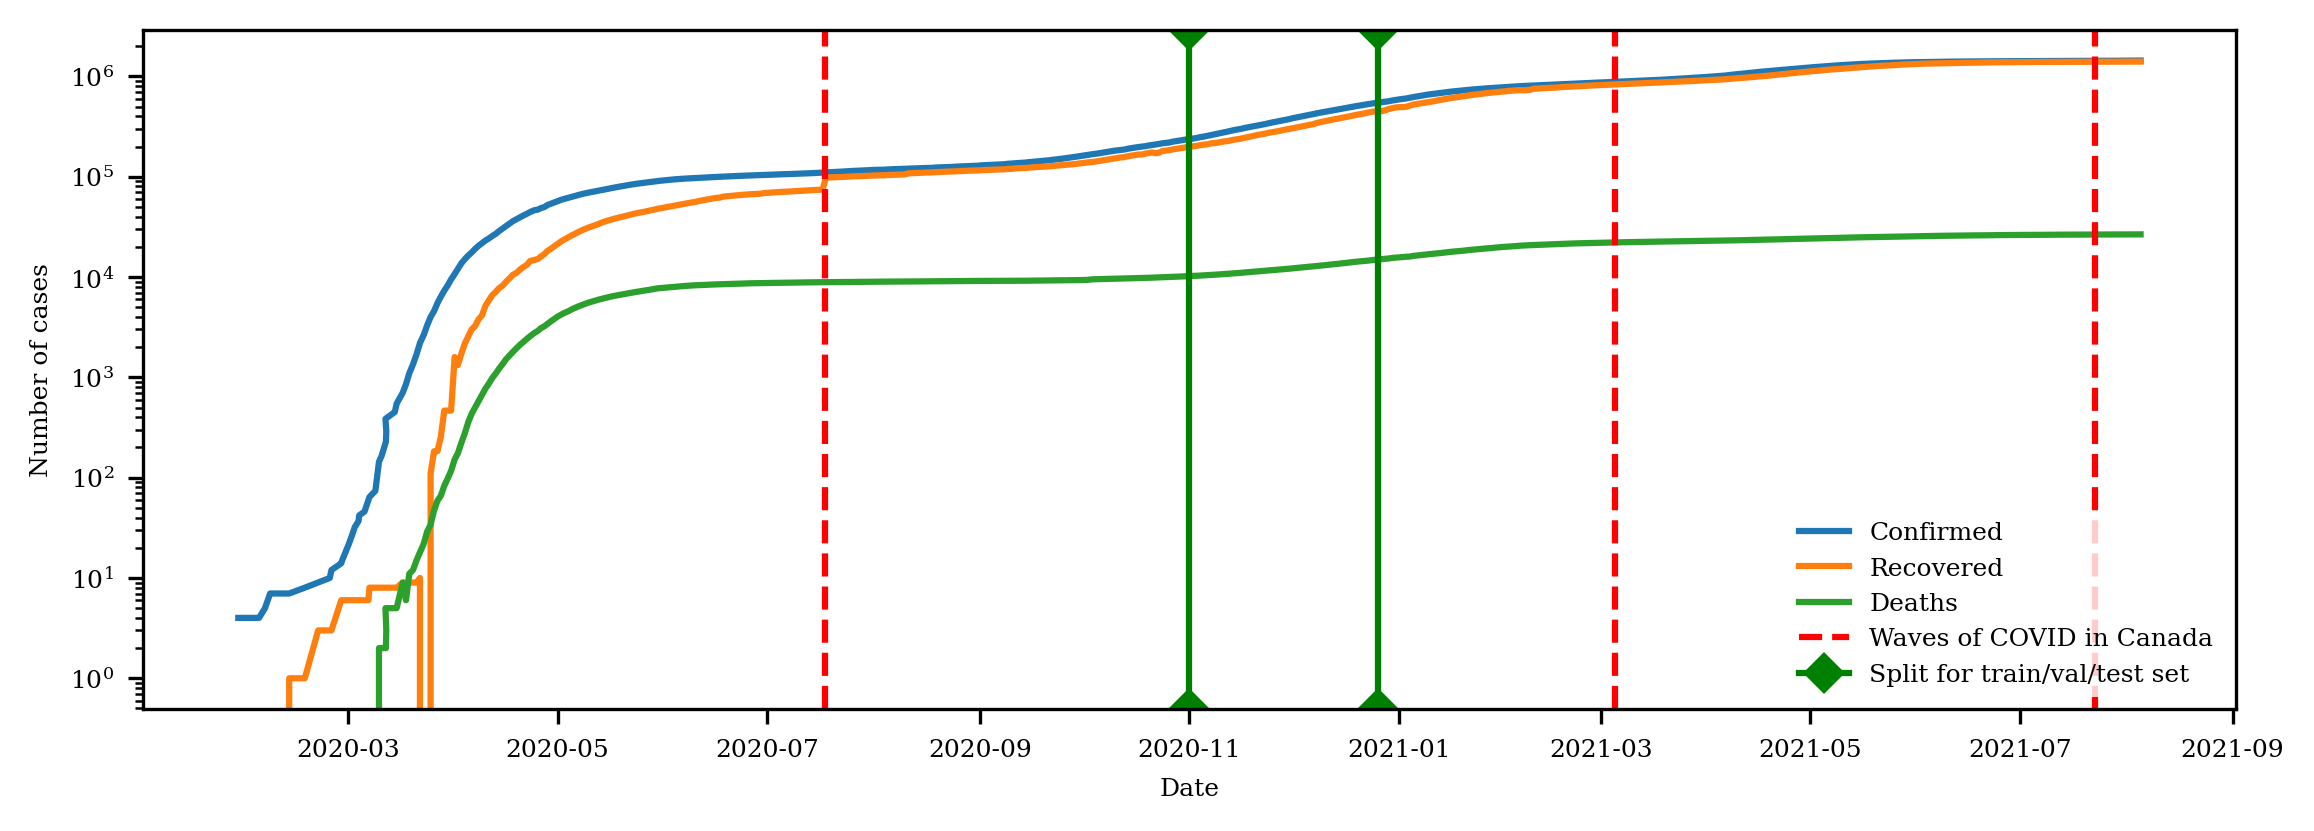

In [193]:
# plotting the line 1 points 
plt.plot(last_update_pydatetime, canada['Confirmed'], label = "Confirmed")
plt.plot(last_update_pydatetime, canada['Recovered'], label = "Recovered")
plt.plot(last_update_pydatetime, canada['Deaths'], label = "Deaths")
plt.axvline(x = datetime(2020,7,18,0,0,0), linestyle='--', color = 'r', label = 'Waves of COVID in Canada')
plt.axvline(x = datetime(2021,3,5,0,0,0), linestyle='--', color = 'r')
plt.axvline(x = datetime(2021,7,23,0,0,0), linestyle='--', color = 'r')
plt.axvline(x = datetime(2020,11,1,0,0,0), marker='D', color = 'g', label = 'Split for train/val/test set')
plt.axvline(x = datetime(2020,12,26,0,0,0), marker='D', color = 'g')
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Number of cases')
# show a legend on the plot
plt.legend()
# Display a figure.
tikzplotlib.save("cases.tikz")
plt.show()